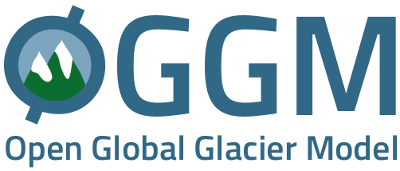

# Getting started with flowline models: Mass Balance Gradients

In [1]:
# The commands below are just importing the necessary modules and functions
# Plot defaults
%matplotlib inline
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (9, 6)  # Default plot size
# Scientific packages
import numpy as np
import pandas as pd

# Constants
from oggm import cfg
cfg.initialize()
# OGGM models
from oggm.core.massbalance import LinearMassBalance
from oggm.core.flowline import FluxBasedModel, RectangularBedFlowline, TrapezoidalBedFlowline, ParabolicBedFlowline
# There are several solvers in OGGM core. We use the default one for this experiment
FlowlineModel = FluxBasedModel

2019-01-01 13:46:52: oggm.cfg: Using configuration file: /home/zora/Dokumente/git/oggm/oggm/params.cfg


We set-up a simple run with a linear bed, like we do it in the flowline_model Notebook. 

In [2]:
# This is the bed rock, linearily decreasing from 3400m altitude to 1400m, in 200 steps
nx = 200
bed_h = np.linspace(3400, 1400, nx)
# At the begining, there is no glacier so our glacier surface is at the bed altitude
surface_h = bed_h
# Let's set the model grid spacing to 100m 
map_dx = 100
# calculate the corresponding distance along the glacier (from the top)
distance_along_glacier = np.linspace(0,nx, nx) *0.1 # in km 
# The units of widths is in "grid points", i.e. 3 grid points = 300 m in our case
widths = np.zeros(nx) + 3.
# Define our bed
init_flowline = RectangularBedFlowline(surface_h=surface_h, bed_h=bed_h, widths=widths, map_dx=map_dx)

## Playing around with the Mass Balance Gradient (MBG)
The [MBG](http://www.antarcticglaciers.org/modern-glaciers/introduction-glacier-mass-balance/#SECTION_3) depends strongly on the climate. Changing the MBG influences for example the glacier's response time.
Let's have a look at some examples.

In [3]:
# We will calculate models with the MBGs: 1, 4 and 10 (in the 
# previous examples we worked with grad=4 all the time)
grad = [1, 4, 10]
# In the following lists the intermediate steps of the models will be saved
mb_models = []
annual_mb = []
# here the "final" models will be saved
models = []
colors = ['C1', 'C3', 'C5'] # colors for the graphs

for k, gradient in enumerate(grad):
    a = LinearMassBalance(3000, grad=gradient)
    mb_models.append(a)
    # Calculation of the annual mass balance along the glacier profile
    annual_mb.append(a.get_annual_mb(surface_h) * cfg.SEC_IN_YEAR)
    # The models require the initial glacier bed, a mass-balance model, and an initial time (the year y0)
    models.append(FlowlineModel(init_flowline, mb_model=a, y0=0.))
    # First, look at the state of the glacier models after 300 years
    models[k].run_until(300)

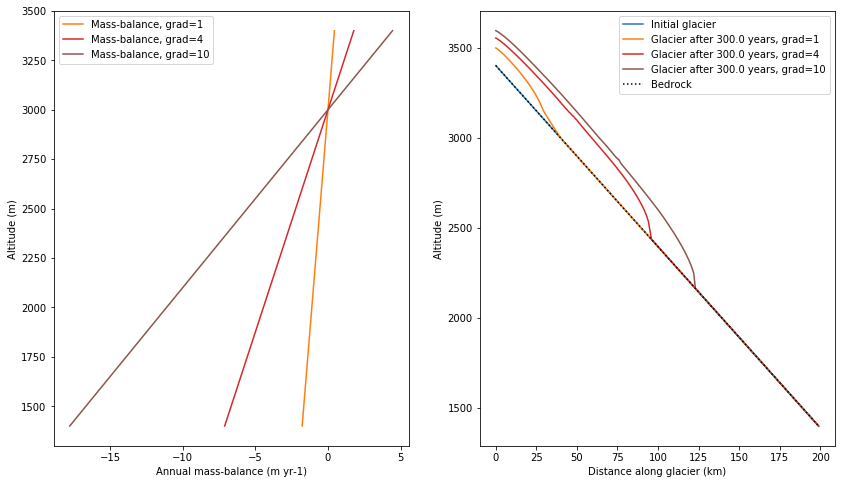

In [4]:
# Plot it for 300 years
plt.figure(figsize=[14,8])

plt.subplot(121)
# Annual mass balance
for k, ann_mb in enumerate(annual_mb):
    plt.plot(ann_mb, bed_h, color=colors[k], label='Mass-balance, grad='+ str(grad[k]))
plt.xlabel('Annual mass-balance (m yr-1)')
plt.ylabel('Altitude (m)')
plt.legend(loc='best');

plt.subplot(122)
# Plot the initial conditions first:
plt.plot(init_flowline.surface_h, label='Initial glacier')
# Get the modelled flowline (model.fls[-1]) and plot its new surface
for k, model in enumerate(models):
    plt.plot(model.fls[-1].surface_h, label='Glacier after {} years, '.format(model.yr) + 'grad=' + str(grad[k]), color=colors[k])
# Add the bedrock:
plt.plot(init_flowline.bed_h, color='k', label='Bedrock', linestyle = ':', linewidth=1.5)
plt.xlabel('Distance along glacier (km)')
plt.ylabel('Altitude (m)')
plt.legend(loc='best');

Different mass balance gradients lead to different annual mass balances with the result that higher gradients show shallower slopes. The model with the highest gradient shows the longest und thickest glacier. 

We will look at the glaciers' state when they reach the equilibrium.

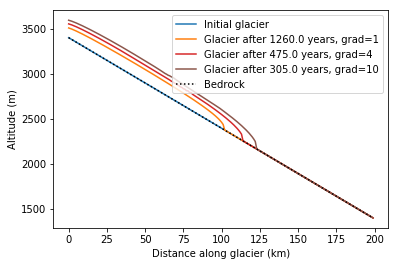

In [5]:
# Plot it
plt.plot(init_flowline.surface_h, label='Initial glacier')

for k, model in enumerate(models):
    model.run_until_equilibrium()
    # Get the modelled flowline (model.fls[-1]) and plot its new surface
    plt.plot(model.fls[-1].surface_h, label='Glacier after {} years, '.format(model.yr) + 'grad=' + str(grad[k]), color=colors[k])
# Add the bedrock:
plt.plot(init_flowline.bed_h, color='k', label='Bedrock', linestyle = ':', linewidth=1.5)
plt.xlabel('Distance along glacier (km)')
plt.ylabel('Altitude (m)')
plt.legend(loc='best');

The different models reach their equilibrium state after different amounts of years. The figure shows that a higher gradient comes along with a bigger glacier. Let's look at specific numbers: 

In [6]:
# create lists with different properties of the glacier models
volume = []
area = []
length = []
year = []

for model in models:
    year.append(model.yr)
    volume.append(model.volume_km3)
    length.append(model.length_m)
    area.append(model.area_km2)

# grad noch automatisch abrufen
dic = {'grad': [1, 4, 10], 'year': year, 'volume': volume, 'area': area, 'length': length}
table = pd.DataFrame.from_dict(dic)
table

,grad,year,volume,area,length
0,1,1260.0,0.412196,3.06,10200.0
1,4,475.0,0.614229,3.42,11400.0
2,10,305.0,0.810094,3.69,12300.0


The next plot shows the dependecy of the volume on the mass balance gradient:

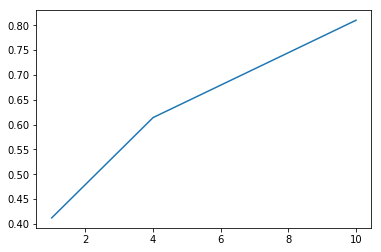

In [7]:
plt.plot(table['grad'], table['volume']);

Let's add some more values. The calculation will take a little bit longer.

In [8]:
# We will calculate models with the MBGs: 1 to 21 with stepsize 2
grad = list(range(1,21,2))
# In the following lists the intermediate steps of the models willbe saved
mb_models = []
annual_mb = []
# here the "final" models will be saved
models = []
                               
for k, gradient in enumerate(grad):
    a = LinearMassBalance(3000, grad=gradient)
    mb_models.append(a)
    # Calculation of the annual mass balance along the glacier profile
    annual_mb.append(a.get_annual_mb(surface_h) * cfg.SEC_IN_YEAR)
    # The models require the initial glacier bed, a mass-balance model, and an initial time (the year y0)
    models.append(FlowlineModel(init_flowline, mb_model=a, y0=0.))
    # First, look at the state of the glacier models after 300 years
    models[k].run_until(300)


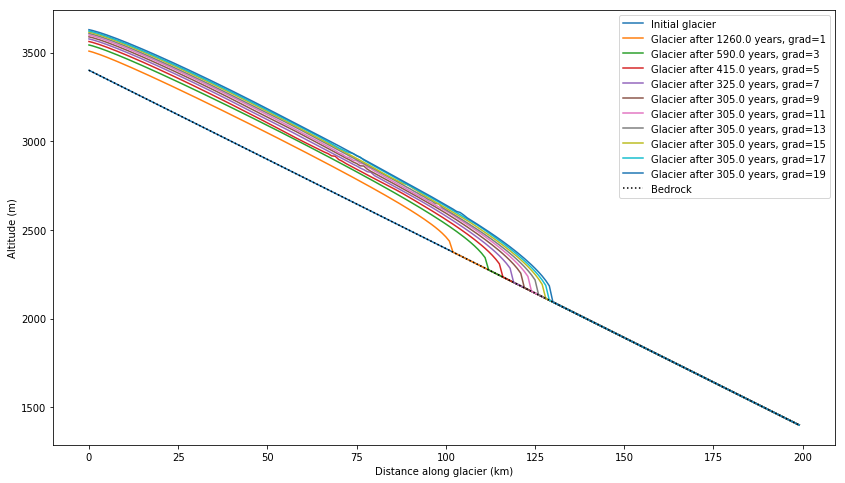

In [9]:
# Plot it
plt.figure(figsize=[14,8])
plt.plot(init_flowline.surface_h, label='Initial glacier')

for k, model in enumerate(models):
    model.run_until_equilibrium()
    # Get the modelled flowline (model.fls[-1]) and plot its new surface
    plt.plot(model.fls[-1].surface_h, label='Glacier after {} years, '.format(model.yr) + 'grad=' + str(grad[k]))#, color=colors[k])
# Add the bedrock:
plt.plot(init_flowline.bed_h, color='k', label='Bedrock', linestyle = ':', linewidth=1.5)
plt.xlabel('Distance along glacier (km)')
plt.ylabel('Altitude (m)')
plt.legend(loc='best');

In [10]:
# create lists with different properties of the glacier models
volume = []
area = []
length = []
year = []

for model in models:
    year.append(model.yr)
    volume.append(model.volume_km3)
    length.append(model.length_m)
    area.append(model.area_km2)

dic = {'grad': grad, 'year': year, 'volume': volume, 'area': area, 'length': length}
table = pd.DataFrame.from_dict(dic)

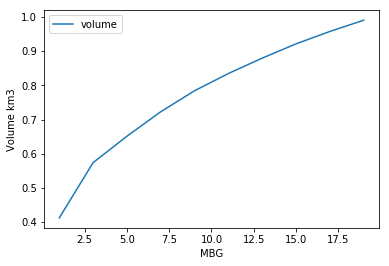

In [11]:
# plot it
plt.plot(table['grad'], table['volume'])
plt.xlabel('MBG')
plt.ylabel('Volume km3')
plt.legend(loc='best');